In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
import datetime


%matplotlib inline
from RL_env.config import config
from RL_env.marketdata.yahoodownloader import YahooDownloader
from RL_env.preprocessing.preprocessors import FeatureEngineer
from RL_env.preprocessing.data import data_split
from RL_env.env.env_stocktrading import StockTradingEnv
from RL_env.model.models import DRLAgent,DRLEnsembleAgent
from RL_env.trade.backtest import backtest_stats, get_baseline, backtest_plot
from RL_env.trade.backtest import convert_daily_return_to_pyfolio_ts,get_daily_return


from pprint import pprint
from pyfolio import timeseries

import sys
sys.path.append("../FinRL-Library")

import itertools

In [2]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

In [3]:
start_date=config.START_DATE
end_date=config.END_DATE

In [4]:
df = YahooDownloader(start_date = start_date,
                     end_date = end_date,
                     ticker_list = config.PRO3_10_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (52840, 8)


In [5]:
# df.to_csv('susa.csv')

In [6]:
df.head()

,date,open,high,low,close,volume,tic,day
0,2000-01-03,16.145832,16.333332,15.062500,12.189544,2333700.0,CMCSA,0
1,2000-01-03,1.785156,1.800781,1.716797,1.464682,54070400.0,GILD,0
2,2000-01-03,18.875000,18.916668,18.041668,13.683653,933600.0,HES,0
3,2000-01-03,61.840843,62.320229,60.522530,30.766176,1168369.0,KMB,0
4,2000-01-03,147.000000,147.125000,140.125000,65.175705,629450.0,KSU,0


In [7]:
df.tail(10)

,date,open,high,low,close,volume,tic,day
52830,2020-12-31,51.360001,52.480000,51.240002,51.923435,11651200.0,CMCSA,3
52831,2020-12-31,56.599998,58.360001,56.560001,57.604355,10870500.0,GILD,3
52832,2020-12-31,53.480000,53.490002,52.360001,52.605370,1382300.0,HES,3
52833,2020-12-31,133.559998,134.910004,133.149994,132.487061,1480700.0,KMB,3
52834,2020-12-31,202.350006,204.529999,201.369995,203.582443,383400.0,KSU,3
52835,2020-12-31,262.459991,263.829987,260.609985,261.461517,909300.0,LIN,3
52836,2020-12-31,525.460022,526.039978,516.599976,522.019836,4810600.0,NVDA,3
52837,2020-12-31,98.660004,99.800003,98.059998,99.045059,1569300.0,PLD,3
52838,2020-12-31,125.910004,127.570000,125.010002,126.327927,948100.0,SRE,3
52839,2020-12-31,68.480003,68.589996,68.070000,67.787041,4563800.0,TJX,3


In [8]:
df.shape

(52840, 8)

In [9]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    use_turbulence=False,
                    user_defined_feature = True)

df = fe.preprocess_data(df)

Successfully added technical indicators
Successfully added user defined features


In [10]:
df.head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,daily_return,log_return,return_lag_4
0,2000-01-03,16.145832,16.333332,15.062500,12.189544,2333700.0,CMCSA,0,0.0,13.023845,10.442653,0.0,-66.666667,100.0,12.189544,12.189544,-0.879841,-2.118940,0.359951
5284,2000-01-03,1.785156,1.800781,1.716797,1.464682,54070400.0,GILD,0,0.0,13.023845,10.442653,0.0,-66.666667,100.0,1.464682,1.464682,-0.879841,-2.118940,0.359951
10568,2000-01-03,18.875000,18.916668,18.041668,13.683653,933600.0,HES,0,0.0,13.023845,10.442653,0.0,-66.666667,100.0,13.683653,13.683653,8.342402,2.234563,0.359951
15852,2000-01-03,61.840843,62.320229,60.522530,30.766176,1168369.0,KMB,0,0.0,13.023845,10.442653,0.0,-66.666667,100.0,30.766176,30.766176,1.248389,0.810214,0.359951
21136,2000-01-03,147.000000,147.125000,140.125000,65.175705,629450.0,KSU,0,0.0,13.023845,10.442653,0.0,-66.666667,100.0,65.175705,65.175705,1.118421,0.750671,0.359951


In [11]:
# add covariance matrix as states
df=df.sort_values(['date','tic'],ignore_index=True)
df.index = df.date.factorize()[0]

cov_list = []
# look back is one year
lookback=252
for i in range(lookback,len(df.index.unique())):
    data_lookback = df.loc[i-lookback:i,:]
    price_lookback=data_lookback.pivot_table(index = 'date',columns = 'tic', values = 'close')
    return_lookback = price_lookback.pct_change().dropna()
    covs = return_lookback.cov().values 
    cov_list.append(covs)

df_cov = pd.DataFrame({'date':df.date.unique()[lookback:],'cov_list':cov_list})
df = df.merge(df_cov, on='date')
df = df.sort_values(['date','tic']).reset_index(drop=True)

In [12]:
df.shape

(50320, 20)

In [13]:
df.head(10)

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,daily_return,log_return,return_lag_4,cov_list
0,2001-01-02,13.645833,13.750000,13.250000,10.413256,353100.0,CMCSA,1,0.221465,10.946615,8.664207,53.860442,142.526343,20.438134,9.733164,10.022625,2.784837,1.331003,-0.306138,"[[0.0013439860470135028, 0.0001744604023790209..."
1,2001-01-02,2.609375,2.609375,2.289063,1.927983,38233600.0,GILD,1,-0.034864,2.452853,1.798626,45.962001,-28.639485,14.233922,2.063627,2.191394,-0.814853,-1.686605,-0.615873,"[[0.0013439860470135028, 0.0001744604023790209..."
2,2001-01-02,24.395832,25.145832,24.395832,18.741842,3312300.0,HES,1,0.809825,19.479737,13.274779,63.060917,182.263213,45.401985,16.192900,16.115218,8.720958,2.274284,0.590732,"[[0.0013439860470135028, 0.0001744604023790209..."
3,2001-01-02,67.104507,68.130394,66.347076,33.938782,2168084.0,KMB,1,0.476669,35.029619,31.123137,56.342496,100.982771,17.596253,33.153555,31.781587,0.810856,0.593800,1.894365,"[[0.0013439860470135028, 0.0001744604023790209..."
4,2001-01-02,10.125000,10.187500,9.312500,8.514878,517700.0,KSU,1,0.194955,8.799806,6.437343,48.005415,172.606604,28.285790,7.676461,7.738082,-0.749111,-1.382743,2.094846,"[[0.0013439860470135028, 0.0001744604023790209..."
5,2001-01-02,21.812500,22.437500,21.437500,14.563796,1530800.0,LIN,1,0.667557,15.376650,12.022989,60.843162,123.028776,42.401130,13.078371,12.546744,0.710394,0.536724,0.398582,"[[0.0013439860470135028, 0.0001744604023790209..."
6,2001-01-02,5.500000,5.572917,4.968750,4.585903,7270200.0,NVDA,1,-0.911856,8.062424,3.948047,38.842012,-115.394679,38.866691,6.716657,8.333013,-0.685116,-1.155552,1.378601,"[[0.0013439860470135028, 0.0001744604023790209..."
7,2001-01-02,25.687500,25.875000,25.500000,11.667781,102700.0,PLD,1,0.252727,11.997872,10.924835,62.691881,93.540156,37.304306,11.157955,10.868138,1.544271,0.933844,-0.377447,"[[0.0013439860470135028, 0.0001744604023790209..."
8,2001-01-02,23.000000,23.062500,22.250000,11.347570,577500.0,SRE,1,0.067166,12.377176,10.593007,52.391078,-40.367359,7.091459,11.651838,11.013639,-0.027444,-0.027828,-0.665646,"[[0.0013439860470135028, 0.0001744604023790209..."
9,2001-01-02,3.500000,3.570313,3.429688,2.720326,6704000.0,TJX,1,0.034033,2.950872,2.318753,54.598240,89.969486,28.712184,2.594534,2.570033,-0.760272,-1.428252,-0.680521,"[[0.0013439860470135028, 0.0001744604023790209..."


In [14]:
train = data_split(df, config.START_DATE,'2019-01-01')
trade = data_split(df, '2019-01-02', config.END_DATE)

In [15]:
train.head(10)

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,daily_return,log_return,return_lag_4,cov_list
0,2001-01-02,13.645833,13.750000,13.250000,10.413256,353100.0,CMCSA,1,0.221465,10.946615,8.664207,53.860442,142.526343,20.438134,9.733164,10.022625,2.784837,1.331003,-0.306138,"[[0.0013439860470135028, 0.0001744604023790209..."
0,2001-01-02,2.609375,2.609375,2.289063,1.927983,38233600.0,GILD,1,-0.034864,2.452853,1.798626,45.962001,-28.639485,14.233922,2.063627,2.191394,-0.814853,-1.686605,-0.615873,"[[0.0013439860470135028, 0.0001744604023790209..."
0,2001-01-02,24.395832,25.145832,24.395832,18.741842,3312300.0,HES,1,0.809825,19.479737,13.274779,63.060917,182.263213,45.401985,16.192900,16.115218,8.720958,2.274284,0.590732,"[[0.0013439860470135028, 0.0001744604023790209..."
0,2001-01-02,67.104507,68.130394,66.347076,33.938782,2168084.0,KMB,1,0.476669,35.029619,31.123137,56.342496,100.982771,17.596253,33.153555,31.781587,0.810856,0.593800,1.894365,"[[0.0013439860470135028, 0.0001744604023790209..."
0,2001-01-02,10.125000,10.187500,9.312500,8.514878,517700.0,KSU,1,0.194955,8.799806,6.437343,48.005415,172.606604,28.285790,7.676461,7.738082,-0.749111,-1.382743,2.094846,"[[0.0013439860470135028, 0.0001744604023790209..."
0,2001-01-02,21.812500,22.437500,21.437500,14.563796,1530800.0,LIN,1,0.667557,15.376650,12.022989,60.843162,123.028776,42.401130,13.078371,12.546744,0.710394,0.536724,0.398582,"[[0.0013439860470135028, 0.0001744604023790209..."
0,2001-01-02,5.500000,5.572917,4.968750,4.585903,7270200.0,NVDA,1,-0.911856,8.062424,3.948047,38.842012,-115.394679,38.866691,6.716657,8.333013,-0.685116,-1.155552,1.378601,"[[0.0013439860470135028, 0.0001744604023790209..."
0,2001-01-02,25.687500,25.875000,25.500000,11.667781,102700.0,PLD,1,0.252727,11.997872,10.924835,62.691881,93.540156,37.304306,11.157955,10.868138,1.544271,0.933844,-0.377447,"[[0.0013439860470135028, 0.0001744604023790209..."
0,2001-01-02,23.000000,23.062500,22.250000,11.347570,577500.0,SRE,1,0.067166,12.377176,10.593007,52.391078,-40.367359,7.091459,11.651838,11.013639,-0.027444,-0.027828,-0.665646,"[[0.0013439860470135028, 0.0001744604023790209..."
0,2001-01-02,3.500000,3.570313,3.429688,2.720326,6704000.0,TJX,1,0.034033,2.950872,2.318753,54.598240,89.969486,28.712184,2.594534,2.570033,-0.760272,-1.428252,-0.680521,"[[0.0013439860470135028, 0.0001744604023790209..."


In [16]:
train.tail(10)

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,daily_return,log_return,return_lag_4,cov_list
4526,2018-12-31,34.290001,34.599998,33.299999,32.514961,21613200.0,CMCSA,0,-0.895439,37.599543,30.878680,42.452085,-127.169820,27.902798,34.903233,34.721072,-0.237016,-0.270518,-0.782718,"[[0.0003117349234995929, 0.0001261003070277830..."
4526,2018-12-31,62.000000,63.070000,61.580002,57.231087,7584000.0,GILD,0,-1.668329,65.637368,54.638085,40.235449,-126.970868,47.103344,60.692329,63.121890,0.760146,0.565397,-0.569254,"[[0.0003117349234995929, 0.0001261003070277830..."
4526,2018-12-31,40.650002,41.320000,40.080002,38.793671,4513500.0,HES,0,-4.089177,57.049506,34.392246,33.174111,-132.891854,53.297449,47.999679,53.581761,-0.322157,-0.388840,-0.296767,"[[0.0003117349234995929, 0.0001261003070277830..."
4526,2018-12-31,113.440002,114.290001,112.070000,105.348389,1876200.0,KMB,0,0.398188,109.528726,100.611281,52.752493,12.054459,1.180050,104.412343,101.837469,1.715608,0.999016,0.056416,"[[0.0003117349234995929, 0.0001261003070277830..."
4526,2018-12-31,95.849998,96.389999,94.879997,93.196739,613500.0,KSU,0,-1.643292,100.537737,88.013909,43.189222,-57.851201,3.739838,95.234611,98.115672,-0.115347,-0.122560,1.186921,"[[0.0003117349234995929, 0.0001261003070277830..."
4526,2018-12-31,156.229996,157.000000,153.940002,149.385696,1853900.0,LIN,0,-0.904982,155.646230,143.250467,48.868117,-29.594690,15.541690,149.513286,151.779676,0.602907,0.471819,3.594368,"[[0.0003117349234995929, 0.0001261003070277830..."
4526,2018-12-31,135.399994,136.710007,132.259995,132.715775,11628500.0,NVDA,0,-12.202283,167.425729,120.171839,35.949703,-102.241976,36.016148,147.994607,185.317626,-0.111590,-0.118322,1.318946,"[[0.0003117349234995929, 0.0001261003070277830..."
4526,2018-12-31,58.610001,58.759998,57.570000,55.381680,2311400.0,PLD,0,-2.001768,66.316987,51.952303,40.107857,-124.235491,61.726186,60.326374,60.657615,-0.582705,-0.873961,0.427596,"[[0.0003117349234995929, 0.0001261003070277830..."
4526,2018-12-31,107.570000,109.129997,106.540001,100.577728,1838000.0,SRE,0,-1.517092,111.643457,98.001803,43.179104,-144.872769,40.606737,104.600189,105.109588,0.816083,0.596682,-0.045285,"[[0.0003117349234995929, 0.0001261003070277830..."
4526,2018-12-31,44.099998,44.860001,44.060001,43.520153,5582300.0,TJX,0,-1.560495,47.531955,39.965531,40.623526,-53.268504,21.754848,44.689702,48.814936,-0.567298,-0.837707,-0.533029,"[[0.0003117349234995929, 0.0001261003070277830..."


In [17]:
trade.head(10)

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,daily_return,log_return,return_lag_4,cov_list
0,2019-01-02,33.490002,34.450001,33.419998,32.820545,16970400.0,CMCSA,2,-0.856741,37.169594,30.886151,43.792043,-111.312327,27.902798,34.778868,34.710802,-0.245854,-0.282169,-0.780297,"[[0.00031199150063291426, 0.000126412521070618..."
0,2019-01-02,61.759998,64.010002,61.500000,58.045410,7839400.0,GILD,2,-1.566301,64.783223,54.769570,42.062845,-100.874673,35.123770,60.516769,62.931584,0.768569,0.570171,-0.562634,"[[0.00031199150063291426, 0.000126412521070618..."
0,2019-01-02,39.290001,42.400002,39.080002,40.460361,4692200.0,HES,2,-3.894559,56.408546,33.942007,36.033611,-112.198983,44.992828,47.530131,53.102947,-0.302953,-0.360903,-0.269427,"[[0.00031199150063291426, 0.000126412521070618..."
0,2019-01-02,112.800003,113.050003,111.010002,103.360489,2634400.0,KMB,2,0.272574,109.462683,100.441128,50.326454,-51.879602,4.154170,104.473511,101.843616,1.554611,0.937900,0.027668,"[[0.00031199150063291426, 0.000126412521070618..."
0,2019-01-02,93.959999,96.919998,93.879997,93.997391,914400.0,KSU,2,-1.431787,99.561025,88.366396,44.429699,-51.362695,9.004891,95.108894,97.833949,-0.090587,-0.094956,1.159859,"[[0.00031199150063291426, 0.000126412521070618..."
0,2019-01-02,153.529999,158.160004,153.520004,150.496246,1716400.0,LIN,2,-0.682750,155.546138,143.253499,49.762269,-12.452133,11.233366,149.603783,151.655886,0.601068,0.470671,3.585428,"[[0.00031199150063291426, 0.000126412521070618..."
0,2019-01-02,130.639999,138.479996,130.050003,135.419800,12718800.0,NVDA,2,-11.400489,164.625523,120.267033,37.028212,-93.420459,38.349565,145.808601,182.951759,-0.100178,-0.105559,1.332998,"[[0.00031199150063291426, 0.000126412521070618..."
0,2019-01-02,58.040001,58.150002,56.639999,53.787758,2476100.0,PLD,2,-2.084879,65.985694,51.358248,37.615594,-130.390439,64.514420,60.037272,60.531631,-0.602807,-0.923334,0.329394,"[[0.00031199150063291426, 0.000126412521070618..."
0,2019-01-02,107.980003,107.980003,106.089996,99.248322,1196500.0,SRE,2,-1.647074,111.694808,97.253062,41.345303,-158.874909,42.181516,104.498022,104.998427,0.845184,0.612579,-0.039785,"[[0.00031199150063291426, 0.000126412521070618..."
0,2019-01-02,44.230000,45.040001,44.139999,43.442333,5939100.0,TJX,2,-1.403406,46.886579,40.203332,40.455181,-45.941107,19.286866,44.436467,48.648275,-0.562286,-0.826191,-0.537835,"[[0.00031199150063291426, 0.000126412521070618..."


In [18]:
trade.tail(10)

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,daily_return,log_return,return_lag_4,cov_list
504,2020-12-31,51.360001,52.480000,51.240002,51.923435,11651200.0,CMCSA,3,0.579602,51.903071,49.422932,61.440954,113.818140,23.683023,50.481996,47.639419,-0.234133,-0.266747,-0.800091,"[[0.0005812081448381903, 0.0002241317343401599..."
504,2020-12-31,56.599998,58.360001,56.560001,57.604355,10870500.0,GILD,3,-0.727232,60.953325,55.388228,44.138214,-94.910966,11.922424,58.471983,58.966282,0.109410,0.103828,-0.890413,"[[0.0005812081448381903, 0.0002241317343401599..."
504,2020-12-31,53.480000,53.490002,52.360001,52.605370,1382300.0,HES,3,1.403846,57.560829,50.324343,55.015812,10.991584,2.856761,52.186582,45.607633,-0.086781,-0.090780,-0.464360,"[[0.0005812081448381903, 0.0002241317343401599..."
504,2020-12-31,133.559998,134.910004,133.149994,132.487061,1480700.0,KMB,3,-1.139220,135.735363,129.975702,44.863189,-77.096478,12.609709,134.135765,136.291083,1.518508,0.923667,0.062008,"[[0.0005812081448381903, 0.0002241317343401599..."
504,2020-12-31,202.350006,204.529999,201.369995,203.582443,383400.0,KSU,3,3.516539,203.125210,188.337035,63.601579,157.151989,45.168823,192.976379,187.386533,0.536621,0.429586,2.002825,"[[0.0005812081448381903, 0.0002241317343401599..."
504,2020-12-31,262.459991,263.829987,260.609985,261.461517,909300.0,LIN,3,3.287869,261.512069,242.051650,59.252406,165.301092,20.544939,251.608809,243.762066,0.284303,0.250216,4.035520,"[[0.0005812081448381903, 0.0002241317343401599..."
504,2020-12-31,525.460022,526.039978,516.599976,522.019836,4810600.0,NVDA,3,-3.050796,544.860410,510.814205,49.525428,-81.517368,15.258158,528.960089,534.896957,0.996546,0.691418,8.062159,"[[0.0005812081448381903, 0.0002241317343401599..."
504,2020-12-31,98.660004,99.800003,98.059998,99.045059,1569300.0,PLD,3,-0.254858,99.622921,94.489125,50.727249,37.929155,4.710228,97.553937,99.784739,-0.810266,-1.662131,0.882794,"[[0.0005812081448381903, 0.0002241317343401599..."
504,2020-12-31,125.910004,127.570000,125.010002,126.327927,948100.0,SRE,3,-0.587280,130.126919,123.147373,50.291691,-90.611282,5.294020,127.243959,127.207408,0.275459,0.243306,-0.046489,"[[0.0005812081448381903, 0.0002241317343401599..."
504,2020-12-31,68.480003,68.589996,68.070000,67.787041,4563800.0,TJX,3,1.612908,68.276751,64.593387,62.210031,103.657139,45.753201,65.137364,60.607971,-0.463404,-0.622510,-0.667029,"[[0.0005812081448381903, 0.0002241317343401599..."


In [19]:
from RL_env.env.env_portfolio import StockPortfolioEnv

In [20]:
stock_dimension = len(train.tic.unique())
state_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 10, State Space: 10


In [21]:
train.tic.unique()

array(['CMCSA', 'GILD', 'HES', 'KMB', 'KSU', 'LIN', 'NVDA', 'PLD', 'SRE',
       'TJX'], dtype=object)

In [22]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 100000, 
    "transaction_cost_pct": 0.0025, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4,
    "turbulence_threshold":330
}

e_train_gym = StockPortfolioEnv(df = train, **env_kwargs)


In [23]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [24]:
# initialize
agent = DRLAgent(env = env_train)

In [25]:
agent = DRLAgent(env = env_train)
A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.005, "learning_rate": 0.0002}
model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS)

{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0002}
Using cpu device


In [26]:
trained_a2c = agent.train_model(model=model_a2c, 
                                tb_log_name='a2c',
                                total_timesteps=500000)

Logging to tensorboard_log/a2c\a2c_19
-------------------------------------
| time/                 |           |
|    fps                | 166       |
|    iterations         | 100       |
|    time_elapsed       | 3         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -14.2     |
|    explained_variance | -1.43e-06 |
|    learning_rate      | 0.0002    |
|    n_updates          | 99        |
|    policy_loss        | 5.33e+06  |
|    std                | 0.999     |
|    value_loss         | 1.89e+11  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 251      |
|    iterations         | 200      |
|    time_elapsed       | 3        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -14.2    |
|    explained_variance | 1.49e-06 |
|    learning_rate      | 0.0002   |
|    n_updates        

-------------------------------------
| time/                 |           |
|    fps                | 437       |
|    iterations         | 1500      |
|    time_elapsed       | 17        |
|    total_timesteps    | 7500      |
| train/                |           |
|    entropy_loss       | -14.1     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 1499      |
|    policy_loss        | 2.89e+07  |
|    std                | 0.992     |
|    value_loss         | 5.31e+12  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 440      |
|    iterations         | 1600     |
|    time_elapsed       | 18       |
|    total_timesteps    | 8000     |
| train/                |          |
|    entropy_loss       | -14.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 1599     |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 463      |
|    iterations         | 2900     |
|    time_elapsed       | 31       |
|    total_timesteps    | 14500    |
| train/                |          |
|    entropy_loss       | -14      |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 2899     |
|    policy_loss        | 7.35e+06 |
|    std                | 0.981    |
|    value_loss         | 2.56e+11 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 464       |
|    iterations         | 3000      |
|    time_elapsed       | 32        |
|    total_timesteps    | 15000     |
| train/                |           |
|    entropy_loss       | -14       |
|    explained_variance | -3.58e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 2999      |
|    policy_loss        | 1

-------------------------------------
| time/                 |           |
|    fps                | 473       |
|    iterations         | 4300      |
|    time_elapsed       | 45        |
|    total_timesteps    | 21500     |
| train/                |           |
|    entropy_loss       | -13.9     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 4299      |
|    policy_loss        | 5.54e+07  |
|    std                | 0.973     |
|    value_loss         | 1.96e+13  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 474      |
|    iterations         | 4400     |
|    time_elapsed       | 46       |
|    total_timesteps    | 22000    |
| train/                |          |
|    entropy_loss       | -13.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 4399     |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 477      |
|    iterations         | 5600     |
|    time_elapsed       | 58       |
|    total_timesteps    | 28000    |
| train/                |          |
|    entropy_loss       | -13.9    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 5599     |
|    policy_loss        | 7.16e+06 |
|    std                | 0.971    |
|    value_loss         | 3.1e+11  |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 477      |
|    iterations         | 5700     |
|    time_elapsed       | 59       |
|    total_timesteps    | 28500    |
| train/                |          |
|    entropy_loss       | -13.9    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 5699     |
|    policy_loss        | 1.06e+07 |
|

-------------------------------------
| time/                 |           |
|    fps                | 481       |
|    iterations         | 7000      |
|    time_elapsed       | 72        |
|    total_timesteps    | 35000     |
| train/                |           |
|    entropy_loss       | -13.8     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 6999      |
|    policy_loss        | 4.63e+07  |
|    std                | 0.959     |
|    value_loss         | 1.66e+13  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 481      |
|    iterations         | 7100     |
|    time_elapsed       | 73       |
|    total_timesteps    | 35500    |
| train/                |          |
|    entropy_loss       | -13.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 7099     |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 482      |
|    iterations         | 8300     |
|    time_elapsed       | 85       |
|    total_timesteps    | 41500    |
| train/                |          |
|    entropy_loss       | -13.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 8299     |
|    policy_loss        | 6.99e+06 |
|    std                | 0.95     |
|    value_loss         | 4.26e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 483      |
|    iterations         | 8400     |
|    time_elapsed       | 86       |
|    total_timesteps    | 42000    |
| train/                |          |
|    entropy_loss       | -13.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 8399     |
|    policy_loss        | 1.31e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 485      |
|    iterations         | 9700     |
|    time_elapsed       | 99       |
|    total_timesteps    | 48500    |
| train/                |          |
|    entropy_loss       | -13.6    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 9699     |
|    policy_loss        | 3.05e+07 |
|    std                | 0.941    |
|    value_loss         | 8.34e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 485      |
|    iterations         | 9800     |
|    time_elapsed       | 100      |
|    total_timesteps    | 49000    |
| train/                |          |
|    entropy_loss       | -13.6    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 9799     |
|    policy_loss        | 4.32e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 485      |
|    iterations         | 11000    |
|    time_elapsed       | 113      |
|    total_timesteps    | 55000    |
| train/                |          |
|    entropy_loss       | -13.5    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 10999    |
|    policy_loss        | 6.53e+06 |
|    std                | 0.932    |
|    value_loss         | 2.31e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 485      |
|    iterations         | 11100    |
|    time_elapsed       | 114      |
|    total_timesteps    | 55500    |
| train/                |          |
|    entropy_loss       | -13.5    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 11099    |
|    policy_loss        | 8.97e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 486      |
|    iterations         | 12400    |
|    time_elapsed       | 127      |
|    total_timesteps    | 62000    |
| train/                |          |
|    entropy_loss       | -13.3    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 12399    |
|    policy_loss        | 4.47e+07 |
|    std                | 0.92     |
|    value_loss         | 9.72e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 486      |
|    iterations         | 12500    |
|    time_elapsed       | 128      |
|    total_timesteps    | 62500    |
| train/                |          |
|    entropy_loss       | -13.3    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 12499    |
|    policy_loss        | 4.33e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 486      |
|    iterations         | 13700    |
|    time_elapsed       | 140      |
|    total_timesteps    | 68500    |
| train/                |          |
|    entropy_loss       | -13.3    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 13699    |
|    policy_loss        | 5.61e+06 |
|    std                | 0.916    |
|    value_loss         | 2.14e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 487      |
|    iterations         | 13800    |
|    time_elapsed       | 141      |
|    total_timesteps    | 69000    |
| train/                |          |
|    entropy_loss       | -13.3    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 13799    |
|    policy_loss        | 9.25e+06 |
|

-------------------------------------
| time/                 |           |
|    fps                | 487       |
|    iterations         | 15100     |
|    time_elapsed       | 154       |
|    total_timesteps    | 75500     |
| train/                |           |
|    entropy_loss       | -13.2     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 15099     |
|    policy_loss        | 3.18e+07  |
|    std                | 0.906     |
|    value_loss         | 5.88e+12  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 487      |
|    iterations         | 15200    |
|    time_elapsed       | 155      |
|    total_timesteps    | 76000    |
| train/                |          |
|    entropy_loss       | -13.2    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 15199    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 487      |
|    iterations         | 16400    |
|    time_elapsed       | 168      |
|    total_timesteps    | 82000    |
| train/                |          |
|    entropy_loss       | -13.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 16399    |
|    policy_loss        | 4.63e+06 |
|    std                | 0.9      |
|    value_loss         | 1.83e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 487      |
|    iterations         | 16500    |
|    time_elapsed       | 169      |
|    total_timesteps    | 82500    |
| train/                |          |
|    entropy_loss       | -13.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 16499    |
|    policy_loss        | 7.29e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 487      |
|    iterations         | 17800    |
|    time_elapsed       | 182      |
|    total_timesteps    | 89000    |
| train/                |          |
|    entropy_loss       | -13.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 17799    |
|    policy_loss        | 2.21e+07 |
|    std                | 0.894    |
|    value_loss         | 3.84e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 17900    |
|    time_elapsed       | 183      |
|    total_timesteps    | 89500    |
| train/                |          |
|    entropy_loss       | -13.1    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 17899    |
|    policy_loss        | 3.55e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 19200    |
|    time_elapsed       | 196      |
|    total_timesteps    | 96000    |
| train/                |          |
|    entropy_loss       | -13      |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 19199    |
|    policy_loss        | 6.73e+06 |
|    std                | 0.887    |
|    value_loss         | 3.51e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 19300    |
|    time_elapsed       | 197      |
|    total_timesteps    | 96500    |
| train/                |          |
|    entropy_loss       | -13      |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 19299    |
|    policy_loss        | 9.81e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 20600    |
|    time_elapsed       | 210      |
|    total_timesteps    | 103000   |
| train/                |          |
|    entropy_loss       | -12.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 20599    |
|    policy_loss        | 3.05e+07 |
|    std                | 0.88     |
|    value_loss         | 8.49e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 20700    |
|    time_elapsed       | 211      |
|    total_timesteps    | 103500   |
| train/                |          |
|    entropy_loss       | -12.9    |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 20699    |
|    policy_loss        | 4.04e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 21900    |
|    time_elapsed       | 224      |
|    total_timesteps    | 109500   |
| train/                |          |
|    entropy_loss       | -12.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 21899    |
|    policy_loss        | 6.28e+06 |
|    std                | 0.873    |
|    value_loss         | 2.99e+11 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 488       |
|    iterations         | 22000     |
|    time_elapsed       | 225       |
|    total_timesteps    | 110000    |
| train/                |           |
|    entropy_loss       | -12.8     |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 21999     |
|    policy_loss        | 1

------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 23300    |
|    time_elapsed       | 238      |
|    total_timesteps    | 116500   |
| train/                |          |
|    entropy_loss       | -12.7    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 23299    |
|    policy_loss        | 4.21e+07 |
|    std                | 0.865    |
|    value_loss         | 1.1e+13  |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 23400    |
|    time_elapsed       | 239      |
|    total_timesteps    | 117000   |
| train/                |          |
|    entropy_loss       | -12.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 23399    |
|    policy_loss        | 4.75e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 489      |
|    iterations         | 24600    |
|    time_elapsed       | 251      |
|    total_timesteps    | 123000   |
| train/                |          |
|    entropy_loss       | -12.6    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 24599    |
|    policy_loss        | 6.24e+06 |
|    std                | 0.855    |
|    value_loss         | 3.1e+11  |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 489       |
|    iterations         | 24700     |
|    time_elapsed       | 252       |
|    total_timesteps    | 123500    |
| train/                |           |
|    entropy_loss       | -12.6     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 24699     |
|    policy_loss        | 1

------------------------------------
| time/                 |          |
|    fps                | 489      |
|    iterations         | 26000    |
|    time_elapsed       | 265      |
|    total_timesteps    | 130000   |
| train/                |          |
|    entropy_loss       | -12.5    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 25999    |
|    policy_loss        | 3.4e+07  |
|    std                | 0.844    |
|    value_loss         | 9.01e+12 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 489       |
|    iterations         | 26100     |
|    time_elapsed       | 266       |
|    total_timesteps    | 130500    |
| train/                |           |
|    entropy_loss       | -12.5     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 26099     |
|    policy_loss        | 3

-------------------------------------
| time/                 |           |
|    fps                | 489       |
|    iterations         | 27300     |
|    time_elapsed       | 278       |
|    total_timesteps    | 136500    |
| train/                |           |
|    entropy_loss       | -12.4     |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 27299     |
|    policy_loss        | 5.27e+06  |
|    std                | 0.837     |
|    value_loss         | 2.21e+11  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 489      |
|    iterations         | 27400    |
|    time_elapsed       | 279      |
|    total_timesteps    | 137000   |
| train/                |          |
|    entropy_loss       | -12.4    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 27399    |
|    policy_loss       

-------------------------------------
| time/                 |           |
|    fps                | 489       |
|    iterations         | 28700     |
|    time_elapsed       | 293       |
|    total_timesteps    | 143500    |
| train/                |           |
|    entropy_loss       | -12.3     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 28699     |
|    policy_loss        | 3.01e+07  |
|    std                | 0.829     |
|    value_loss         | 9.32e+12  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 489      |
|    iterations         | 28800    |
|    time_elapsed       | 294      |
|    total_timesteps    | 144000   |
| train/                |          |
|    entropy_loss       | -12.3    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 28799    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 489      |
|    iterations         | 30000    |
|    time_elapsed       | 306      |
|    total_timesteps    | 150000   |
| train/                |          |
|    entropy_loss       | -12.3    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 29999    |
|    policy_loss        | 4.57e+06 |
|    std                | 0.825    |
|    value_loss         | 2.2e+11  |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 489      |
|    iterations         | 30100    |
|    time_elapsed       | 307      |
|    total_timesteps    | 150500   |
| train/                |          |
|    entropy_loss       | -12.2    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 30099    |
|    policy_loss        | 8.42e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 490      |
|    iterations         | 31400    |
|    time_elapsed       | 320      |
|    total_timesteps    | 157000   |
| train/                |          |
|    entropy_loss       | -12.2    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 31399    |
|    policy_loss        | 3.09e+07 |
|    std                | 0.818    |
|    value_loss         | 7.46e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 490      |
|    iterations         | 31500    |
|    time_elapsed       | 321      |
|    total_timesteps    | 157500   |
| train/                |          |
|    entropy_loss       | -12.2    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 31499    |
|    policy_loss        | 4.75e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 490      |
|    iterations         | 32700    |
|    time_elapsed       | 333      |
|    total_timesteps    | 163500   |
| train/                |          |
|    entropy_loss       | -12.1    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 32699    |
|    policy_loss        | 5.13e+06 |
|    std                | 0.809    |
|    value_loss         | 1.79e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 490      |
|    iterations         | 32800    |
|    time_elapsed       | 334      |
|    total_timesteps    | 164000   |
| train/                |          |
|    entropy_loss       | -12.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 32799    |
|    policy_loss        | 7.78e+06 |
|

-------------------------------------
| time/                 |           |
|    fps                | 490       |
|    iterations         | 34100     |
|    time_elapsed       | 347       |
|    total_timesteps    | 170500    |
| train/                |           |
|    entropy_loss       | -11.9     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 34099     |
|    policy_loss        | 3e+07     |
|    std                | 0.798     |
|    value_loss         | 7.56e+12  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 490      |
|    iterations         | 34200    |
|    time_elapsed       | 348      |
|    total_timesteps    | 171000   |
| train/                |          |
|    entropy_loss       | -11.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 34199    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 490      |
|    iterations         | 35500    |
|    time_elapsed       | 361      |
|    total_timesteps    | 177500   |
| train/                |          |
|    entropy_loss       | -11.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 35499    |
|    policy_loss        | 7.97e+06 |
|    std                | 0.787    |
|    value_loss         | 5.48e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 490      |
|    iterations         | 35600    |
|    time_elapsed       | 362      |
|    total_timesteps    | 178000   |
| train/                |          |
|    entropy_loss       | -11.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 35599    |
|    policy_loss        | 1.49e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 490      |
|    iterations         | 36900    |
|    time_elapsed       | 375      |
|    total_timesteps    | 184500   |
| train/                |          |
|    entropy_loss       | -11.7    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 36899    |
|    policy_loss        | 4.41e+07 |
|    std                | 0.781    |
|    value_loss         | 1.89e+13 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 490      |
|    iterations         | 37000    |
|    time_elapsed       | 377      |
|    total_timesteps    | 185000   |
| train/                |          |
|    entropy_loss       | -11.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 36999    |
|    policy_loss        | 5.05e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 490      |
|    iterations         | 38200    |
|    time_elapsed       | 389      |
|    total_timesteps    | 191000   |
| train/                |          |
|    entropy_loss       | -11.5    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 38199    |
|    policy_loss        | 5.2e+06  |
|    std                | 0.769    |
|    value_loss         | 3.91e+11 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 490       |
|    iterations         | 38300     |
|    time_elapsed       | 390       |
|    total_timesteps    | 191500    |
| train/                |           |
|    entropy_loss       | -11.5     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 38299     |
|    policy_loss        | 9

-------------------------------------
| time/                 |           |
|    fps                | 490       |
|    iterations         | 39600     |
|    time_elapsed       | 403       |
|    total_timesteps    | 198000    |
| train/                |           |
|    entropy_loss       | -11.4     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 39599     |
|    policy_loss        | 3.03e+07  |
|    std                | 0.759     |
|    value_loss         | 1.05e+13  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 490      |
|    iterations         | 39700    |
|    time_elapsed       | 404      |
|    total_timesteps    | 198500   |
| train/                |          |
|    entropy_loss       | -11.4    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 39699    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 490      |
|    iterations         | 40900    |
|    time_elapsed       | 417      |
|    total_timesteps    | 204500   |
| train/                |          |
|    entropy_loss       | -11.3    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 40899    |
|    policy_loss        | 4.94e+06 |
|    std                | 0.751    |
|    value_loss         | 3.53e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 490      |
|    iterations         | 41000    |
|    time_elapsed       | 418      |
|    total_timesteps    | 205000   |
| train/                |          |
|    entropy_loss       | -11.3    |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 40999    |
|    policy_loss        | 1.04e+07 |
|

-------------------------------------
| time/                 |           |
|    fps                | 490       |
|    iterations         | 42300     |
|    time_elapsed       | 431       |
|    total_timesteps    | 211500    |
| train/                |           |
|    entropy_loss       | -11.2     |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 42299     |
|    policy_loss        | 2.4e+07   |
|    std                | 0.744     |
|    value_loss         | 6.87e+12  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 490       |
|    iterations         | 42400     |
|    time_elapsed       | 432       |
|    total_timesteps    | 212000    |
| train/                |           |
|    entropy_loss       | -11.2     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 42399     |
|    policy_

------------------------------------
| time/                 |          |
|    fps                | 490      |
|    iterations         | 43600    |
|    time_elapsed       | 444      |
|    total_timesteps    | 218000   |
| train/                |          |
|    entropy_loss       | -11.1    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 43599    |
|    policy_loss        | 5.84e+06 |
|    std                | 0.736    |
|    value_loss         | 2.57e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 490      |
|    iterations         | 43700    |
|    time_elapsed       | 445      |
|    total_timesteps    | 218500   |
| train/                |          |
|    entropy_loss       | -11.1    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 43699    |
|    policy_loss        | 8.7e+06  |
|

------------------------------------
| time/                 |          |
|    fps                | 490      |
|    iterations         | 45000    |
|    time_elapsed       | 458      |
|    total_timesteps    | 225000   |
| train/                |          |
|    entropy_loss       | -11      |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 44999    |
|    policy_loss        | 3.24e+07 |
|    std                | 0.73     |
|    value_loss         | 1.02e+13 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 490      |
|    iterations         | 45100    |
|    time_elapsed       | 459      |
|    total_timesteps    | 225500   |
| train/                |          |
|    entropy_loss       | -11      |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 45099    |
|    policy_loss        | 4.15e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 490      |
|    iterations         | 46300    |
|    time_elapsed       | 471      |
|    total_timesteps    | 231500   |
| train/                |          |
|    entropy_loss       | -10.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 46299    |
|    policy_loss        | 6.1e+06  |
|    std                | 0.722    |
|    value_loss         | 2.29e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 490      |
|    iterations         | 46400    |
|    time_elapsed       | 472      |
|    total_timesteps    | 232000   |
| train/                |          |
|    entropy_loss       | -10.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 46399    |
|    policy_loss        | 7.92e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 490      |
|    iterations         | 47700    |
|    time_elapsed       | 485      |
|    total_timesteps    | 238500   |
| train/                |          |
|    entropy_loss       | -10.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 47699    |
|    policy_loss        | 2.7e+07  |
|    std                | 0.713    |
|    value_loss         | 7.66e+12 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 490       |
|    iterations         | 47800     |
|    time_elapsed       | 486       |
|    total_timesteps    | 239000    |
| train/                |           |
|    entropy_loss       | -10.8     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 47799     |
|    policy_loss        | 3

------------------------------------
| time/                 |          |
|    fps                | 490      |
|    iterations         | 49000    |
|    time_elapsed       | 499      |
|    total_timesteps    | 245000   |
| train/                |          |
|    entropy_loss       | -10.7    |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 48999    |
|    policy_loss        | 4.13e+06 |
|    std                | 0.708    |
|    value_loss         | 1.5e+11  |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 490      |
|    iterations         | 49100    |
|    time_elapsed       | 500      |
|    total_timesteps    | 245500   |
| train/                |          |
|    entropy_loss       | -10.7    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 49099    |
|    policy_loss        | 6.11e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 490      |
|    iterations         | 50400    |
|    time_elapsed       | 513      |
|    total_timesteps    | 252000   |
| train/                |          |
|    entropy_loss       | -10.6    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 50399    |
|    policy_loss        | 2.42e+07 |
|    std                | 0.699    |
|    value_loss         | 7.45e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 490      |
|    iterations         | 50500    |
|    time_elapsed       | 514      |
|    total_timesteps    | 252500   |
| train/                |          |
|    entropy_loss       | -10.6    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 50499    |
|    policy_loss        | 3.95e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 490      |
|    iterations         | 51800    |
|    time_elapsed       | 527      |
|    total_timesteps    | 259000   |
| train/                |          |
|    entropy_loss       | -10.5    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 51799    |
|    policy_loss        | 6.7e+06  |
|    std                | 0.691    |
|    value_loss         | 5.51e+11 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 490       |
|    iterations         | 51900     |
|    time_elapsed       | 528       |
|    total_timesteps    | 259500    |
| train/                |           |
|    entropy_loss       | -10.4     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 51899     |
|    policy_loss        | 1

------------------------------------
| time/                 |          |
|    fps                | 491      |
|    iterations         | 53200    |
|    time_elapsed       | 541      |
|    total_timesteps    | 266000   |
| train/                |          |
|    entropy_loss       | -10.4    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 53199    |
|    policy_loss        | 3.24e+07 |
|    std                | 0.685    |
|    value_loss         | 1.7e+13  |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 491      |
|    iterations         | 53300    |
|    time_elapsed       | 542      |
|    total_timesteps    | 266500   |
| train/                |          |
|    entropy_loss       | -10.4    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 53299    |
|    policy_loss        | 4.72e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 490      |
|    iterations         | 54500    |
|    time_elapsed       | 555      |
|    total_timesteps    | 272500   |
| train/                |          |
|    entropy_loss       | -10.2    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 54499    |
|    policy_loss        | 6.36e+06 |
|    std                | 0.676    |
|    value_loss         | 3.89e+11 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 490       |
|    iterations         | 54600     |
|    time_elapsed       | 556       |
|    total_timesteps    | 273000    |
| train/                |           |
|    entropy_loss       | -10.2     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 54599     |
|    policy_loss        | 7

-------------------------------------
| time/                 |           |
|    fps                | 490       |
|    iterations         | 55900     |
|    time_elapsed       | 569       |
|    total_timesteps    | 279500    |
| train/                |           |
|    entropy_loss       | -10.1     |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 55899     |
|    policy_loss        | 3.12e+07  |
|    std                | 0.668     |
|    value_loss         | 1.39e+13  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 490      |
|    iterations         | 56000    |
|    time_elapsed       | 570      |
|    total_timesteps    | 280000   |
| train/                |          |
|    entropy_loss       | -10.1    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 55999    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 490      |
|    iterations         | 57200    |
|    time_elapsed       | 582      |
|    total_timesteps    | 286000   |
| train/                |          |
|    entropy_loss       | -10      |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 57199    |
|    policy_loss        | 5.76e+06 |
|    std                | 0.663    |
|    value_loss         | 3.52e+11 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 490       |
|    iterations         | 57300     |
|    time_elapsed       | 583       |
|    total_timesteps    | 286500    |
| train/                |           |
|    entropy_loss       | -10       |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 57299     |
|    policy_loss        | 8

------------------------------------
| time/                 |          |
|    fps                | 490      |
|    iterations         | 58600    |
|    time_elapsed       | 596      |
|    total_timesteps    | 293000   |
| train/                |          |
|    entropy_loss       | -9.93    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 58599    |
|    policy_loss        | 2.33e+07 |
|    std                | 0.655    |
|    value_loss         | 8.83e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 490      |
|    iterations         | 58700    |
|    time_elapsed       | 597      |
|    total_timesteps    | 293500   |
| train/                |          |
|    entropy_loss       | -9.91    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 58699    |
|    policy_loss        | 3.11e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 490      |
|    iterations         | 59900    |
|    time_elapsed       | 610      |
|    total_timesteps    | 299500   |
| train/                |          |
|    entropy_loss       | -9.79    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 59899    |
|    policy_loss        | 5.92e+06 |
|    std                | 0.647    |
|    value_loss         | 2.67e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 490      |
|    iterations         | 60000    |
|    time_elapsed       | 611      |
|    total_timesteps    | 300000   |
| train/                |          |
|    entropy_loss       | -9.79    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 59999    |
|    policy_loss        | 6.9e+06  |
|

-------------------------------------
| time/                 |           |
|    fps                | 490       |
|    iterations         | 61300     |
|    time_elapsed       | 624       |
|    total_timesteps    | 306500    |
| train/                |           |
|    entropy_loss       | -9.69     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 61299     |
|    policy_loss        | 2.89e+07  |
|    std                | 0.641     |
|    value_loss         | 7.52e+12  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 490      |
|    iterations         | 61400    |
|    time_elapsed       | 625      |
|    total_timesteps    | 307000   |
| train/                |          |
|    entropy_loss       | -9.69    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 61399    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 490      |
|    iterations         | 62600    |
|    time_elapsed       | 637      |
|    total_timesteps    | 313000   |
| train/                |          |
|    entropy_loss       | -9.58    |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 62599    |
|    policy_loss        | 3.87e+06 |
|    std                | 0.633    |
|    value_loss         | 2.44e+11 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 490       |
|    iterations         | 62700     |
|    time_elapsed       | 638       |
|    total_timesteps    | 313500    |
| train/                |           |
|    entropy_loss       | -9.58     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 62699     |
|    policy_loss        | 6

------------------------------------
| time/                 |          |
|    fps                | 490      |
|    iterations         | 64000    |
|    time_elapsed       | 651      |
|    total_timesteps    | 320000   |
| train/                |          |
|    entropy_loss       | -9.49    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 63999    |
|    policy_loss        | 2.25e+07 |
|    std                | 0.628    |
|    value_loss         | 9.23e+12 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 490       |
|    iterations         | 64100     |
|    time_elapsed       | 652       |
|    total_timesteps    | 320500    |
| train/                |           |
|    entropy_loss       | -9.49     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 64099     |
|    policy_loss        | 2

------------------------------------
| time/                 |          |
|    fps                | 490      |
|    iterations         | 65300    |
|    time_elapsed       | 664      |
|    total_timesteps    | 326500   |
| train/                |          |
|    entropy_loss       | -9.4     |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 65299    |
|    policy_loss        | 3.12e+06 |
|    std                | 0.622    |
|    value_loss         | 1.54e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 490      |
|    iterations         | 65400    |
|    time_elapsed       | 665      |
|    total_timesteps    | 327000   |
| train/                |          |
|    entropy_loss       | -9.39    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 65399    |
|    policy_loss        | 6.41e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 491      |
|    iterations         | 66700    |
|    time_elapsed       | 679      |
|    total_timesteps    | 333500   |
| train/                |          |
|    entropy_loss       | -9.32    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 66699    |
|    policy_loss        | 1.96e+07 |
|    std                | 0.618    |
|    value_loss         | 7.3e+12  |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 491      |
|    iterations         | 66800    |
|    time_elapsed       | 680      |
|    total_timesteps    | 334000   |
| train/                |          |
|    entropy_loss       | -9.32    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 66799    |
|    policy_loss        | 4.02e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 491      |
|    iterations         | 68100    |
|    time_elapsed       | 693      |
|    total_timesteps    | 340500   |
| train/                |          |
|    entropy_loss       | -9.26    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 68099    |
|    policy_loss        | 4.25e+06 |
|    std                | 0.614    |
|    value_loss         | 4.07e+11 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 491       |
|    iterations         | 68200     |
|    time_elapsed       | 694       |
|    total_timesteps    | 341000    |
| train/                |           |
|    entropy_loss       | -9.24     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 68199     |
|    policy_loss        | 8

------------------------------------
| time/                 |          |
|    fps                | 491      |
|    iterations         | 69500    |
|    time_elapsed       | 707      |
|    total_timesteps    | 347500   |
| train/                |          |
|    entropy_loss       | -9.12    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 69499    |
|    policy_loss        | 2.88e+07 |
|    std                | 0.606    |
|    value_loss         | 1.57e+13 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 491       |
|    iterations         | 69600     |
|    time_elapsed       | 708       |
|    total_timesteps    | 348000    |
| train/                |           |
|    entropy_loss       | -9.11     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 69599     |
|    policy_loss        | 3

------------------------------------
| time/                 |          |
|    fps                | 491      |
|    iterations         | 70800    |
|    time_elapsed       | 720      |
|    total_timesteps    | 354000   |
| train/                |          |
|    entropy_loss       | -9.07    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 70799    |
|    policy_loss        | 5.66e+06 |
|    std                | 0.604    |
|    value_loss         | 3.9e+11  |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 491       |
|    iterations         | 70900     |
|    time_elapsed       | 721       |
|    total_timesteps    | 354500    |
| train/                |           |
|    entropy_loss       | -9.06     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 70899     |
|    policy_loss        | 7

-------------------------------------
| time/                 |           |
|    fps                | 491       |
|    iterations         | 72200     |
|    time_elapsed       | 734       |
|    total_timesteps    | 361000    |
| train/                |           |
|    entropy_loss       | -8.9      |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 72199     |
|    policy_loss        | 3.44e+07  |
|    std                | 0.594     |
|    value_loss         | 1.42e+13  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 491      |
|    iterations         | 72300    |
|    time_elapsed       | 735      |
|    total_timesteps    | 361500   |
| train/                |          |
|    entropy_loss       | -8.9     |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 72299    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 491      |
|    iterations         | 73500    |
|    time_elapsed       | 748      |
|    total_timesteps    | 367500   |
| train/                |          |
|    entropy_loss       | -8.81    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 73499    |
|    policy_loss        | 4.3e+06  |
|    std                | 0.588    |
|    value_loss         | 3.64e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 491      |
|    iterations         | 73600    |
|    time_elapsed       | 749      |
|    total_timesteps    | 368000   |
| train/                |          |
|    entropy_loss       | -8.82    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 73599    |
|    policy_loss        | 8.6e+06  |
|

------------------------------------
| time/                 |          |
|    fps                | 491      |
|    iterations         | 74900    |
|    time_elapsed       | 762      |
|    total_timesteps    | 374500   |
| train/                |          |
|    entropy_loss       | -8.72    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 74899    |
|    policy_loss        | 2.4e+07  |
|    std                | 0.583    |
|    value_loss         | 9.14e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 491      |
|    iterations         | 75000    |
|    time_elapsed       | 763      |
|    total_timesteps    | 375000   |
| train/                |          |
|    entropy_loss       | -8.69    |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 74999    |
|    policy_loss        | 2.88e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 491      |
|    iterations         | 76200    |
|    time_elapsed       | 775      |
|    total_timesteps    | 381000   |
| train/                |          |
|    entropy_loss       | -8.6     |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 76199    |
|    policy_loss        | 4.64e+06 |
|    std                | 0.576    |
|    value_loss         | 2.57e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 491      |
|    iterations         | 76300    |
|    time_elapsed       | 776      |
|    total_timesteps    | 381500   |
| train/                |          |
|    entropy_loss       | -8.6     |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 76299    |
|    policy_loss        | 6.8e+06  |
|

------------------------------------
| time/                 |          |
|    fps                | 491      |
|    iterations         | 77600    |
|    time_elapsed       | 789      |
|    total_timesteps    | 388000   |
| train/                |          |
|    entropy_loss       | -8.5     |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 77599    |
|    policy_loss        | 2.16e+07 |
|    std                | 0.571    |
|    value_loss         | 1.04e+13 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 491      |
|    iterations         | 77700    |
|    time_elapsed       | 790      |
|    total_timesteps    | 388500   |
| train/                |          |
|    entropy_loss       | -8.5     |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 77699    |
|    policy_loss        | 3.01e+07 |
|

-------------------------------------
| time/                 |           |
|    fps                | 491       |
|    iterations         | 78900     |
|    time_elapsed       | 803       |
|    total_timesteps    | 394500    |
| train/                |           |
|    entropy_loss       | -8.41     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 78899     |
|    policy_loss        | 3.62e+06  |
|    std                | 0.566     |
|    value_loss         | 2.19e+11  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 491       |
|    iterations         | 79000     |
|    time_elapsed       | 804       |
|    total_timesteps    | 395000    |
| train/                |           |
|    entropy_loss       | -8.4      |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 78999     |
|    policy_

-------------------------------------
| time/                 |           |
|    fps                | 491       |
|    iterations         | 80300     |
|    time_elapsed       | 817       |
|    total_timesteps    | 401500    |
| train/                |           |
|    entropy_loss       | -8.31     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 80299     |
|    policy_loss        | 1.89e+07  |
|    std                | 0.561     |
|    value_loss         | 5.55e+12  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 491       |
|    iterations         | 80400     |
|    time_elapsed       | 818       |
|    total_timesteps    | 402000    |
| train/                |           |
|    entropy_loss       | -8.31     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 80399     |
|    policy_

------------------------------------
| time/                 |          |
|    fps                | 491      |
|    iterations         | 81600    |
|    time_elapsed       | 830      |
|    total_timesteps    | 408000   |
| train/                |          |
|    entropy_loss       | -8.22    |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 81599    |
|    policy_loss        | 3.28e+06 |
|    std                | 0.556    |
|    value_loss         | 1.77e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 491      |
|    iterations         | 81700    |
|    time_elapsed       | 831      |
|    total_timesteps    | 408500   |
| train/                |          |
|    entropy_loss       | -8.21    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 81699    |
|    policy_loss        | 4.95e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 491      |
|    iterations         | 83000    |
|    time_elapsed       | 844      |
|    total_timesteps    | 415000   |
| train/                |          |
|    entropy_loss       | -8.09    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 82999    |
|    policy_loss        | 1.42e+07 |
|    std                | 0.549    |
|    value_loss         | 4.42e+12 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 491       |
|    iterations         | 83100     |
|    time_elapsed       | 845       |
|    total_timesteps    | 415500    |
| train/                |           |
|    entropy_loss       | -8.08     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 83099     |
|    policy_loss        | 2

------------------------------------
| time/                 |          |
|    fps                | 491      |
|    iterations         | 84400    |
|    time_elapsed       | 859      |
|    total_timesteps    | 422000   |
| train/                |          |
|    entropy_loss       | -7.94    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 84399    |
|    policy_loss        | 4.51e+06 |
|    std                | 0.541    |
|    value_loss         | 4.54e+11 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 491       |
|    iterations         | 84500     |
|    time_elapsed       | 860       |
|    total_timesteps    | 422500    |
| train/                |           |
|    entropy_loss       | -7.92     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 84499     |
|    policy_loss        | 7

------------------------------------
| time/                 |          |
|    fps                | 491      |
|    iterations         | 85800    |
|    time_elapsed       | 873      |
|    total_timesteps    | 429000   |
| train/                |          |
|    entropy_loss       | -7.81    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 85799    |
|    policy_loss        | 3.11e+07 |
|    std                | 0.534    |
|    value_loss         | 1.37e+13 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 491      |
|    iterations         | 85900    |
|    time_elapsed       | 874      |
|    total_timesteps    | 429500   |
| train/                |          |
|    entropy_loss       | -7.8     |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 85899    |
|    policy_loss        | 2.44e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 491      |
|    iterations         | 87100    |
|    time_elapsed       | 886      |
|    total_timesteps    | 435500   |
| train/                |          |
|    entropy_loss       | -7.68    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 87099    |
|    policy_loss        | 3.51e+06 |
|    std                | 0.528    |
|    value_loss         | 2.89e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 491      |
|    iterations         | 87200    |
|    time_elapsed       | 887      |
|    total_timesteps    | 436000   |
| train/                |          |
|    entropy_loss       | -7.67    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 87199    |
|    policy_loss        | 6.14e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 491      |
|    iterations         | 88500    |
|    time_elapsed       | 900      |
|    total_timesteps    | 442500   |
| train/                |          |
|    entropy_loss       | -7.58    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 88499    |
|    policy_loss        | 2.36e+07 |
|    std                | 0.523    |
|    value_loss         | 8.98e+12 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 491       |
|    iterations         | 88600     |
|    time_elapsed       | 901       |
|    total_timesteps    | 443000    |
| train/                |           |
|    entropy_loss       | -7.57     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 88599     |
|    policy_loss        | 2

------------------------------------
| time/                 |          |
|    fps                | 491      |
|    iterations         | 89800    |
|    time_elapsed       | 914      |
|    total_timesteps    | 449000   |
| train/                |          |
|    entropy_loss       | -7.48    |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 89799    |
|    policy_loss        | 3.65e+06 |
|    std                | 0.518    |
|    value_loss         | 2.77e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 491      |
|    iterations         | 89900    |
|    time_elapsed       | 915      |
|    total_timesteps    | 449500   |
| train/                |          |
|    entropy_loss       | -7.47    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 89899    |
|    policy_loss        | 4.96e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 491      |
|    iterations         | 91200    |
|    time_elapsed       | 928      |
|    total_timesteps    | 456000   |
| train/                |          |
|    entropy_loss       | -7.38    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 91199    |
|    policy_loss        | 1.92e+07 |
|    std                | 0.513    |
|    value_loss         | 9.97e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 491      |
|    iterations         | 91300    |
|    time_elapsed       | 929      |
|    total_timesteps    | 456500   |
| train/                |          |
|    entropy_loss       | -7.37    |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 91299    |
|    policy_loss        | 2.09e+07 |
|

-------------------------------------
| time/                 |           |
|    fps                | 491       |
|    iterations         | 92500     |
|    time_elapsed       | 941       |
|    total_timesteps    | 462500    |
| train/                |           |
|    entropy_loss       | -7.25     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 92499     |
|    policy_loss        | 3.67e+06  |
|    std                | 0.507     |
|    value_loss         | 3e+11     |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 491      |
|    iterations         | 92600    |
|    time_elapsed       | 942      |
|    total_timesteps    | 463000   |
| train/                |          |
|    entropy_loss       | -7.24    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 92599    |
|    policy_loss       

-------------------------------------
| time/                 |           |
|    fps                | 491       |
|    iterations         | 93900     |
|    time_elapsed       | 955       |
|    total_timesteps    | 469500    |
| train/                |           |
|    entropy_loss       | -7.14     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 93899     |
|    policy_loss        | 1.93e+07  |
|    std                | 0.502     |
|    value_loss         | 8.39e+12  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 491      |
|    iterations         | 94000    |
|    time_elapsed       | 956      |
|    total_timesteps    | 470000   |
| train/                |          |
|    entropy_loss       | -7.13    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 93999    |
|    policy_loss       

-------------------------------------
| time/                 |           |
|    fps                | 491       |
|    iterations         | 95200     |
|    time_elapsed       | 969       |
|    total_timesteps    | 476000    |
| train/                |           |
|    entropy_loss       | -7.03     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 95199     |
|    policy_loss        | 3.09e+06  |
|    std                | 0.497     |
|    value_loss         | 2.21e+11  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 491      |
|    iterations         | 95300    |
|    time_elapsed       | 970      |
|    total_timesteps    | 476500   |
| train/                |          |
|    entropy_loss       | -7.02    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 95299    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 491      |
|    iterations         | 96600    |
|    time_elapsed       | 983      |
|    total_timesteps    | 483000   |
| train/                |          |
|    entropy_loss       | -6.9     |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 96599    |
|    policy_loss        | 1.89e+07 |
|    std                | 0.491    |
|    value_loss         | 7.57e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 491      |
|    iterations         | 96700    |
|    time_elapsed       | 984      |
|    total_timesteps    | 483500   |
| train/                |          |
|    entropy_loss       | -6.9     |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 96699    |
|    policy_loss        | 2.32e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 491      |
|    iterations         | 97900    |
|    time_elapsed       | 996      |
|    total_timesteps    | 489500   |
| train/                |          |
|    entropy_loss       | -6.79    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 97899    |
|    policy_loss        | 2.38e+06 |
|    std                | 0.486    |
|    value_loss         | 1.77e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 491      |
|    iterations         | 98000    |
|    time_elapsed       | 997      |
|    total_timesteps    | 490000   |
| train/                |          |
|    entropy_loss       | -6.79    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 97999    |
|    policy_loss        | 3.92e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 491      |
|    iterations         | 99300    |
|    time_elapsed       | 1010     |
|    total_timesteps    | 496500   |
| train/                |          |
|    entropy_loss       | -6.67    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 99299    |
|    policy_loss        | 1.2e+07  |
|    std                | 0.481    |
|    value_loss         | 6.42e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 491      |
|    iterations         | 99400    |
|    time_elapsed       | 1011     |
|    total_timesteps    | 497000   |
| train/                |          |
|    entropy_loss       | -6.66    |
|    explained_variance | 2.38e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 99399    |
|    policy_loss        | 1.9e+07  |
|

In [27]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0003,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=100000)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0003, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device
Logging to tensorboard_log/sac\sac_15
begin_total_asset:100000
end_total_asset:1374073.499241926
Sharpe:  0.7661318195913978
begin_total_asset:100000
end_total_asset:1457854.481000381
Sharpe:  0.7821615312831535
begin_total_asset:100000
end_total_asset:1401739.6963318782
Sharpe:  0.768865398865071
begin_total_asset:100000
end_total_asset:1603596.4935574243
Sharpe:  0.7932523159189893
------------------------------------------------
| environment/       |                         |
|    portfolio_value | 1.6e+06                 |
|    total_reward    | [0, 0.04751576149354... |
| time/              |                         |
|    episodes        | 4                       |
|    fps             | 45                      |
|    time_elapsed    | 400                     |
|    total timesteps | 18108                   |
| train/             |                 

In [28]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.005,
    "learning_rate": 0.0001,
    "batch_size": 128,}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=100000)

{'n_steps': 2048, 'ent_coef': 0.005, 'learning_rate': 0.0001, 'batch_size': 128}
Using cpu device
Logging to tensorboard_log/ppo\ppo_15
-----------------------------
| time/              |      |
|    fps             | 585  |
|    iterations      | 1    |
|    time_elapsed    | 3    |
|    total_timesteps | 2048 |
-----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 577           |
|    iterations           | 2             |
|    time_elapsed         | 7             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 1.3317913e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -14.2         |
|    explained_variance   | 0             |
|    learning_rate        | 0.0001        |
|    loss                 | 8.48e+12      |
|    n_updates            | 10        

-------------------------------------------
| time/                   |               |
|    fps                  | 563           |
|    iterations           | 10            |
|    time_elapsed         | 36            |
|    total_timesteps      | 20480         |
| train/                  |               |
|    approx_kl            | 4.0978193e-08 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -14.2         |
|    explained_variance   | 0             |
|    learning_rate        | 0.0001        |
|    loss                 | 1.54e+14      |
|    n_updates            | 90            |
|    policy_gradient_loss | -4.45e-07     |
|    std                  | 1             |
|    value_loss           | 3.28e+14      |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 562          |
|    iterations           | 11     

-----------------------------------------------------
| environment/            |                         |
|    portfolio_value      | 1.55e+06                |
|    total_reward         | [0, 0.04124681227902... |
| time/                   |                         |
|    fps                  | 563                     |
|    iterations           | 18                      |
|    time_elapsed         | 65                      |
|    total_timesteps      | 36864                   |
| train/                  |                         |
|    approx_kl            | 1.9511208e-07           |
|    clip_fraction        | 0                       |
|    clip_range           | 0.2                     |
|    entropy_loss         | -14.2                   |
|    explained_variance   | 0                       |
|    learning_rate        | 0.0001                  |
|    loss                 | 2.78e+13                |
|    n_updates            | 170                     |
|    policy_gradient_loss | 

-------------------------------------------
| time/                   |               |
|    fps                  | 563           |
|    iterations           | 26            |
|    time_elapsed         | 94            |
|    total_timesteps      | 53248         |
| train/                  |               |
|    approx_kl            | 3.1432137e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -14.2         |
|    explained_variance   | 5.96e-08      |
|    learning_rate        | 0.0001        |
|    loss                 | 8.15e+13      |
|    n_updates            | 250           |
|    policy_gradient_loss | -6.74e-07     |
|    std                  | 1             |
|    value_loss           | 2e+14         |
-------------------------------------------
begin_total_asset:100000
end_total_asset:1302710.2819076544
Sharpe:  0.7619141115146715
-----------------------------------------------------
| environment/        

begin_total_asset:100000
end_total_asset:1717975.8667963087
Sharpe:  0.8333314549604053
-----------------------------------------------------
| environment/            |                         |
|    portfolio_value      | 1.72e+06                |
|    total_reward         | [0, 0.02683358662860... |
| time/                   |                         |
|    fps                  | 562                     |
|    iterations           | 34                      |
|    time_elapsed         | 123                     |
|    total_timesteps      | 69632                   |
| train/                  |                         |
|    approx_kl            | 5.4948032e-08           |
|    clip_fraction        | 0                       |
|    clip_range           | 0.2                     |
|    entropy_loss         | -14.2                   |
|    explained_variance   | 0                       |
|    learning_rate        | 0.0001                  |
|    loss                 | 1.09e+14            

begin_total_asset:100000
end_total_asset:1747849.6827960527
Sharpe:  0.8298626222033331
-----------------------------------------------------
| environment/            |                         |
|    portfolio_value      | 1.75e+06                |
|    total_reward         | [0, 0.04917868973135... |
| time/                   |                         |
|    fps                  | 562                     |
|    iterations           | 42                      |
|    time_elapsed         | 152                     |
|    total_timesteps      | 86016                   |
| train/                  |                         |
|    approx_kl            | 2.8871e-08              |
|    clip_fraction        | 0                       |
|    clip_range           | 0.2                     |
|    entropy_loss         | -14.2                   |
|    explained_variance   | 1.79e-07                |
|    learning_rate        | 0.0001                  |
|    loss                 | 1.51e+13            

In [29]:
e_trade_gym = StockPortfolioEnv(df = trade, **env_kwargs)

In [30]:
trade.shape

(5050, 20)

In [31]:
df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_a2c,
                        environment = e_trade_gym)

begin_total_asset:100000
end_total_asset:172931.0814566857
Sharpe:  1.1392917624097385
hit end!


In [32]:
df_daily_return.head()

,date,daily_return
0,2019-01-02,0.000000
1,2019-01-03,-0.014177
2,2019-01-04,0.035724
3,2019-01-07,0.016880
4,2019-01-08,0.012227


In [33]:
df_actions.head()

,CMCSA,GILD,HES,KMB,KSU,LIN,NVDA,PLD,SRE,TJX
date,,,,,,,,,,
2019-01-02,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
2019-01-03,0.075305,0.075305,0.075305,0.130676,0.204701,0.075305,0.075305,0.075305,0.075305,0.137484
2019-01-04,0.068408,0.068408,0.068408,0.149244,0.185951,0.068408,0.068408,0.068408,0.068408,0.185951
2019-01-07,0.072258,0.072258,0.072258,0.101358,0.196418,0.072258,0.072258,0.072258,0.072258,0.196418
2019-01-08,0.065986,0.065986,0.065986,0.179367,0.179367,0.065986,0.065986,0.065986,0.065986,0.179367


In [34]:
df_actions.to_csv('df_actions_a2c_10_3.csv')

In [35]:
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=DRL_strat, 
                              factor_returns=DRL_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")

In [36]:
print("==============DRL Strategy Stats===========")
perf_stats_all

==============DRL Strategy Stats===========


Annual return           0.314320
Cumulative returns      0.729311
Annual volatility       0.272935
Sharpe ratio            1.139292
Calmar ratio            0.921670
Stability               0.766935
Max drawdown           -0.341033
Omega ratio             1.275205
Sortino ratio           1.596078
Skew                   -0.607767
Kurtosis               15.300754
Tail ratio              0.881176
Daily value at risk    -0.033153
Alpha                   0.000000
Beta                    1.000000
dtype: float64

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (506, 8)


Start date,2019-01-02
End date,2020-12-31
Total months,24
,Backtest
Annual return,31.432%
Cumulative returns,72.931%
Annual volatility,27.294%
Sharpe ratio,1.14
Calmar ratio,0.92
Stability,0.77
Max drawdown,-34.103%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,34.10,2020-02-19,2020-03-23,2020-08-05,121
1,10.26,2020-09-02,2020-10-28,2020-11-16,54
2,6.82,2019-05-03,2019-05-31,2019-06-19,34
3,6.46,2019-07-12,2019-08-05,2019-09-04,39
4,4.04,2020-08-17,2020-08-20,2020-09-02,13


Stress Events,mean,min,max
New Normal,0.12%,-11.88%,11.67%


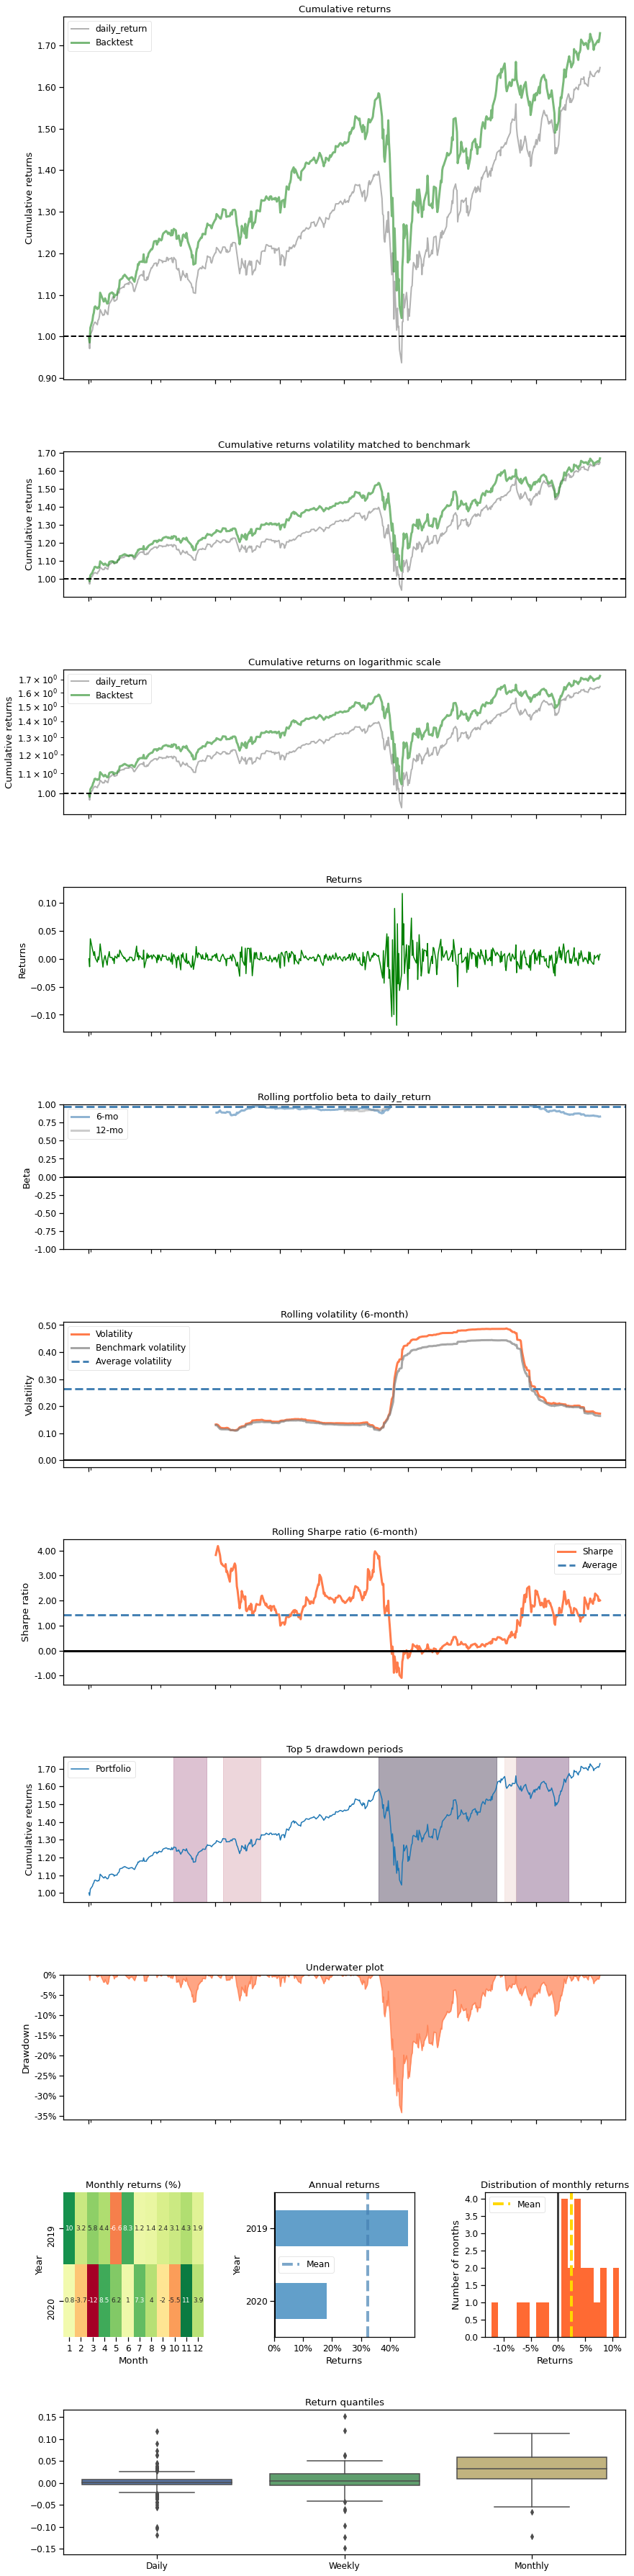

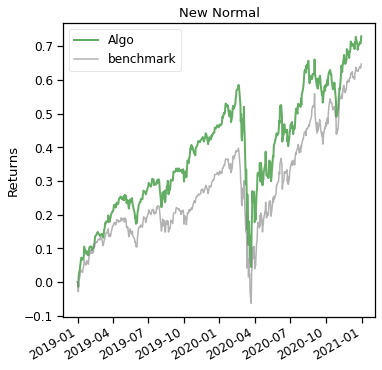

In [37]:
import pyfolio
%matplotlib inline

baseline_df = get_baseline(
        ticker='SUSA', start='2019-01-01', end='2021-01-01'
    )

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                       benchmark_rets=baseline_returns, set_context=False)

In [38]:
df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_ppo,
                        environment = e_trade_gym)

begin_total_asset:100000
end_total_asset:162799.54929557443
Sharpe:  1.0114800192112399
hit end!


In [39]:
df_daily_return

,date,daily_return
0,2019-01-02,0.000000
1,2019-01-03,-0.009192
2,2019-01-04,0.032943
3,2019-01-07,0.016340
4,2019-01-08,0.005177
...,...,...
500,2020-12-24,0.001096
501,2020-12-28,0.003480
502,2020-12-29,-0.001405
503,2020-12-30,0.007332


In [40]:
df_actions.head()

,CMCSA,GILD,HES,KMB,KSU,LIN,NVDA,PLD,SRE,TJX
date,,,,,,,,,,
2019-01-02,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
2019-01-03,0.143988,0.085044,0.143988,0.143988,0.143988,0.052970,0.070798,0.075082,0.087185,0.052970
2019-01-04,0.081774,0.064870,0.064870,0.176335,0.064870,0.176335,0.064870,0.176335,0.064870,0.064870
2019-01-07,0.103233,0.058064,0.058064,0.058064,0.058064,0.149602,0.157833,0.058064,0.157833,0.141180
2019-01-08,0.064038,0.174073,0.073159,0.174073,0.064038,0.084433,0.174073,0.064038,0.064038,0.064038


In [41]:
df_actions.to_csv('df_actions_ppo_10_3.csv')

In [42]:
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=DRL_strat, 
                              factor_returns=DRL_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")

In [43]:
print("==============DRL Strategy Stats===========")
perf_stats_all

==============DRL Strategy Stats===========


Annual return           0.275314
Cumulative returns      0.627995
Annual volatility       0.279461
Sharpe ratio            1.011480
Calmar ratio            0.789197
Stability               0.706024
Max drawdown           -0.348853
Omega ratio             1.236856
Sortino ratio           1.410521
Skew                   -0.716293
Kurtosis               14.237018
Tail ratio              0.833420
Daily value at risk    -0.034087
Alpha                   0.000000
Beta                    1.000000
dtype: float64

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (506, 8)


Start date,2019-01-02
End date,2020-12-31
Total months,24
,Backtest
Annual return,27.531%
Cumulative returns,62.8%
Annual volatility,27.946%
Sharpe ratio,1.01
Calmar ratio,0.79
Stability,0.71
Max drawdown,-34.885%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,34.89,2020-02-19,2020-03-23,2020-08-05,121
1,10.08,2020-09-02,2020-10-28,2020-11-10,50
2,7.30,2019-05-03,2019-05-31,2019-06-20,35
3,6.48,2019-07-26,2019-08-05,2019-08-29,25
4,4.85,2020-01-17,2020-01-31,2020-02-13,20


Stress Events,mean,min,max
New Normal,0.11%,-11.77%,10.66%


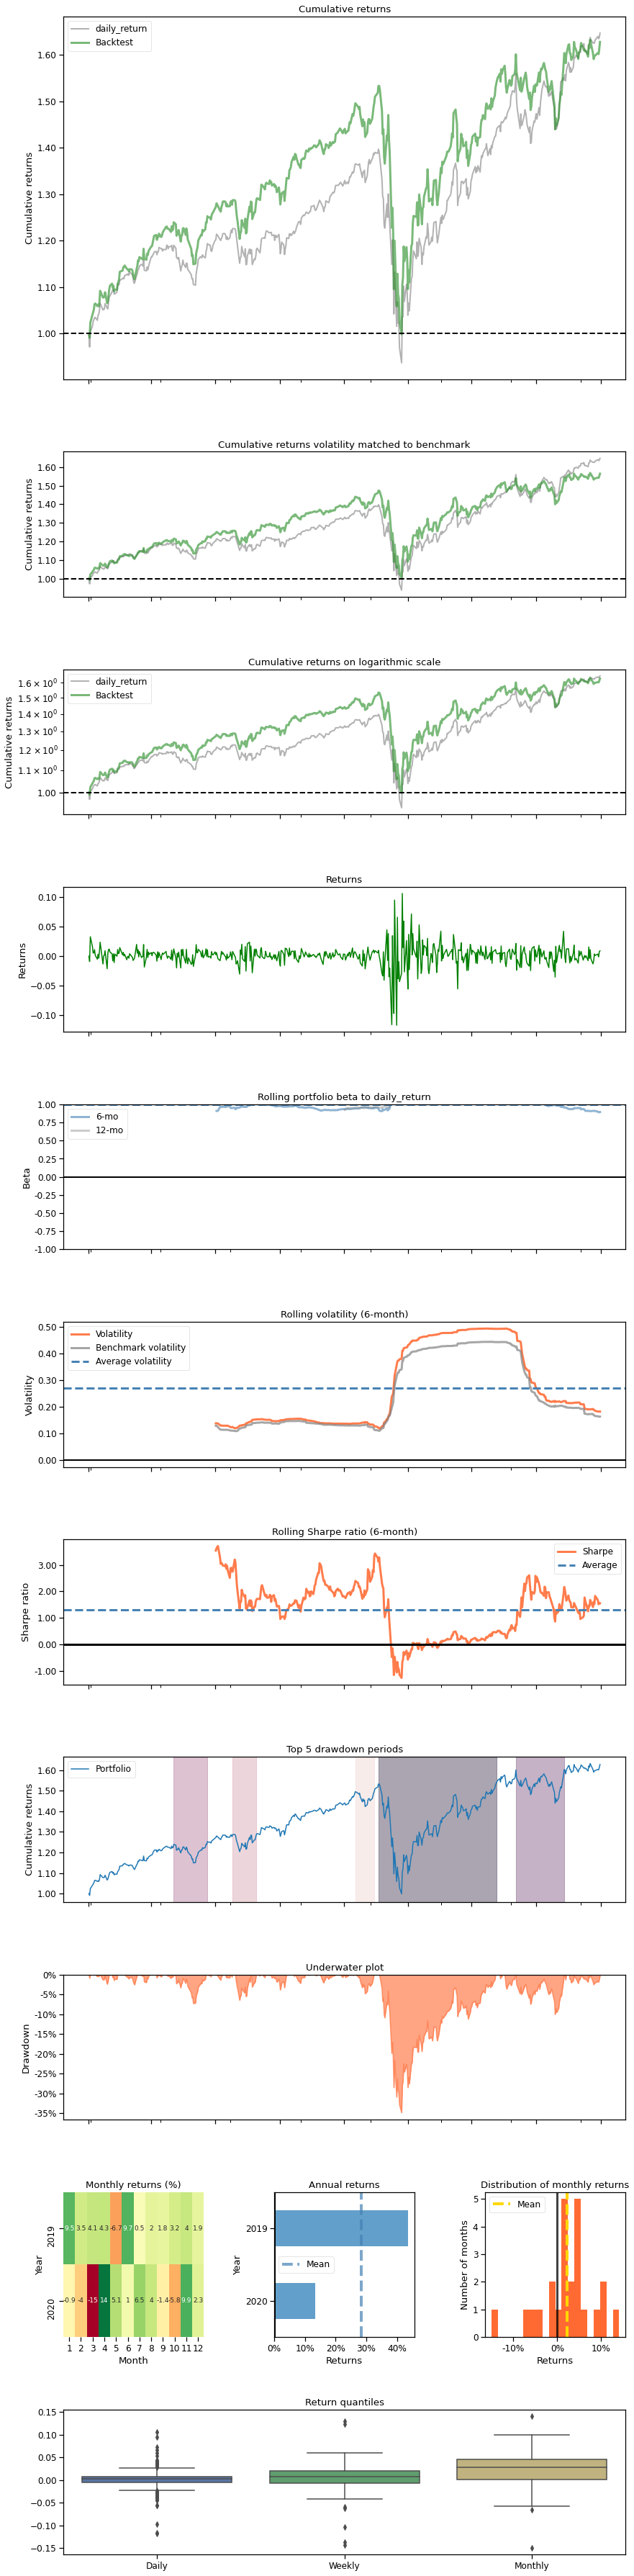

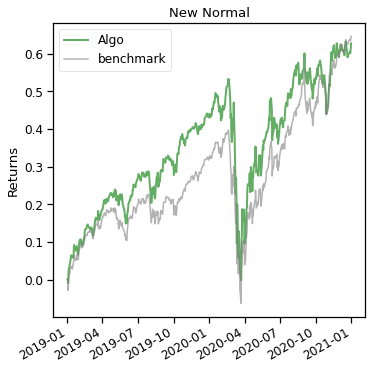

In [44]:
import pyfolio

%matplotlib inline

baseline_df = get_baseline(
        ticker='SUSA', start='2019-01-01', end='2021-01-01'
    )

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                       benchmark_rets=baseline_returns, set_context=False)

In [45]:
df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_sac,
                        environment = e_trade_gym)

begin_total_asset:100000
end_total_asset:180094.1287672693
Sharpe:  1.2244301162393232
hit end!


In [46]:
df_daily_return

,date,daily_return
0,2019-01-02,0.000000
1,2019-01-03,-0.013395
2,2019-01-04,0.039841
3,2019-01-07,0.014300
4,2019-01-08,0.008944
...,...,...
500,2020-12-24,0.000194
501,2020-12-28,0.005073
502,2020-12-29,-0.001567
503,2020-12-30,0.004795


In [47]:
df_actions

,CMCSA,GILD,HES,KMB,KSU,LIN,NVDA,PLD,SRE,TJX
date,,,,,,,,,,
2019-01-02,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
2019-01-03,0.064394,0.141396,0.053987,0.055013,0.106135,0.137290,0.140106,0.053209,0.131290,0.117178
2019-01-04,0.076782,0.152614,0.062351,0.061007,0.062948,0.106544,0.153781,0.058661,0.127634,0.137678
2019-01-07,0.125324,0.137263,0.052243,0.054409,0.139784,0.097644,0.138881,0.061779,0.122219,0.070454
2019-01-08,0.105329,0.129112,0.049565,0.049350,0.128751,0.125895,0.114901,0.049874,0.125568,0.121656
...,...,...,...,...,...,...,...,...,...,...
2020-12-24,0.130439,0.136897,0.051464,0.052257,0.116475,0.079175,0.134347,0.051502,0.135778,0.111666
2020-12-28,0.067565,0.147808,0.055242,0.055771,0.064958,0.118208,0.145999,0.057060,0.142617,0.144771
2020-12-29,0.061246,0.138128,0.051918,0.053901,0.117681,0.111630,0.137951,0.054191,0.135418,0.137935


In [48]:
df_actions.to_csv('df_actions_sac_10_3.csv')

In [49]:
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=DRL_strat, 
                              factor_returns=DRL_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")

In [50]:
print("==============DRL Strategy Stats===========")
perf_stats_all

==============DRL Strategy Stats===========


Annual return           0.341210
Cumulative returns      0.800941
Annual volatility       0.269831
Sharpe ratio            1.224430
Calmar ratio            1.136059
Stability               0.885439
Max drawdown           -0.300345
Omega ratio             1.290479
Sortino ratio           1.723067
Skew                   -0.661314
Kurtosis               14.068782
Tail ratio              0.883214
Daily value at risk    -0.032684
Alpha                   0.000000
Beta                    1.000000
dtype: float64

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (506, 8)


Start date,2019-01-02
End date,2020-12-31
Total months,24
,Backtest
Annual return,34.121%
Cumulative returns,80.094%
Annual volatility,26.983%
Sharpe ratio,1.22
Calmar ratio,1.14
Stability,0.89
Max drawdown,-30.035%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,30.03,2020-02-19,2020-03-23,2020-06-05,78
1,9.48,2020-09-02,2020-10-28,2020-11-16,54
2,7.84,2019-05-03,2019-05-31,2019-06-18,33
3,7.57,2020-06-08,2020-06-26,2020-07-17,30
4,7.12,2019-07-29,2019-08-05,2019-09-05,29


Stress Events,mean,min,max
New Normal,0.13%,-12.12%,10.76%


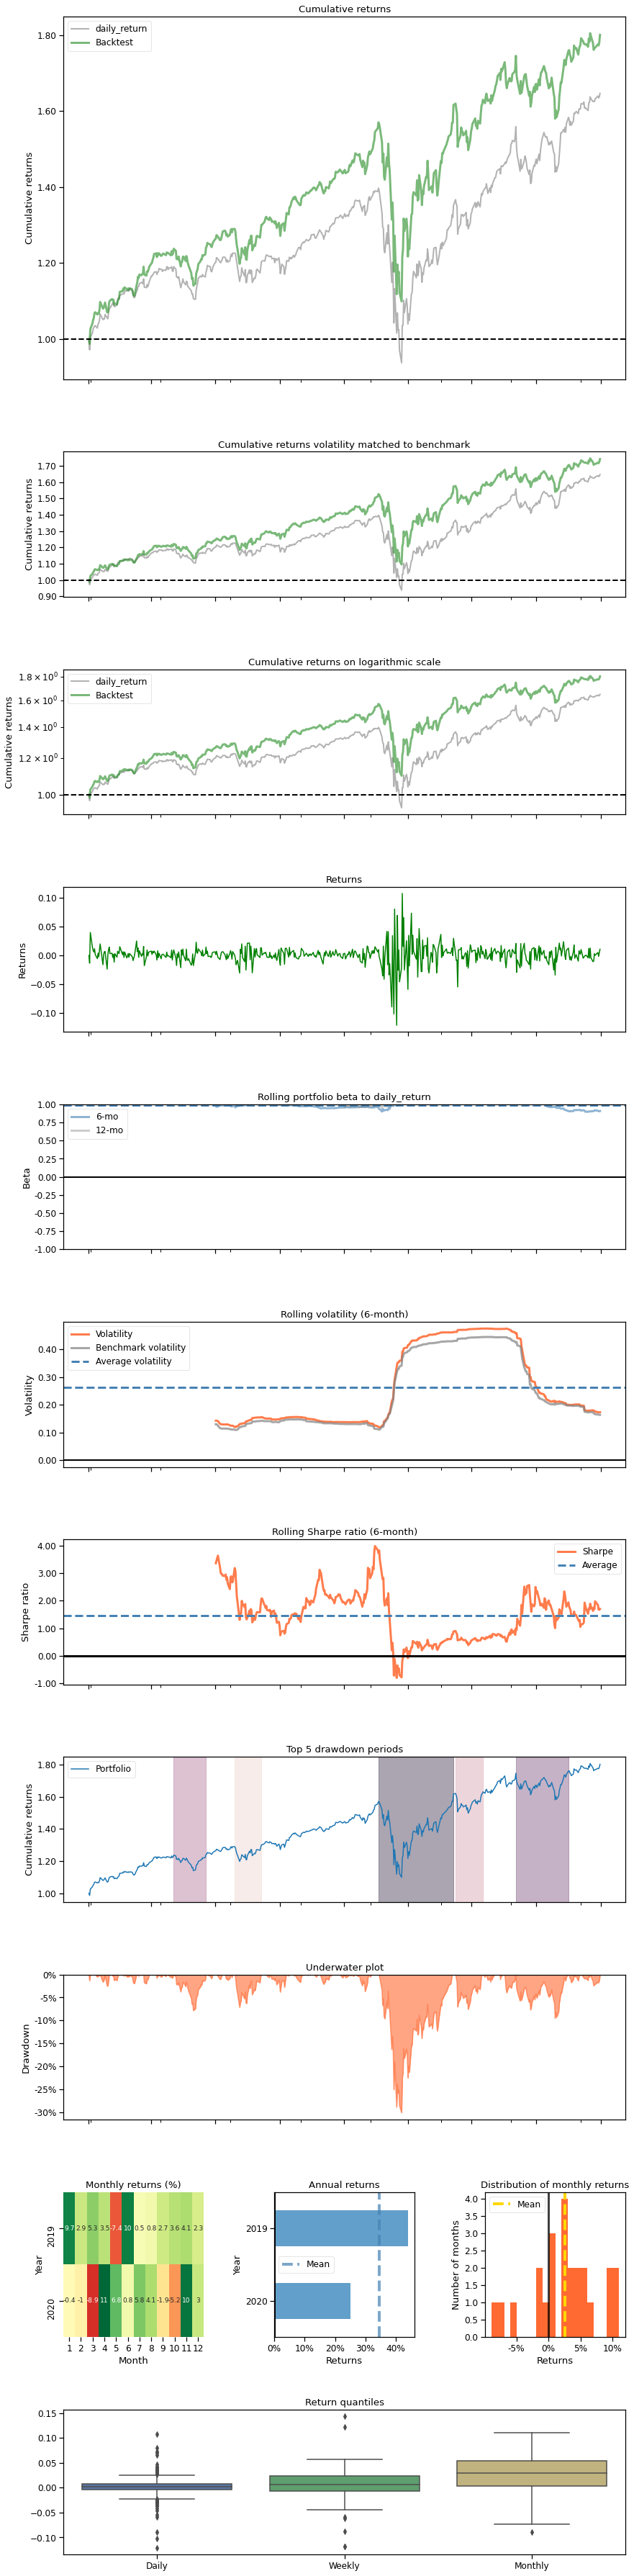

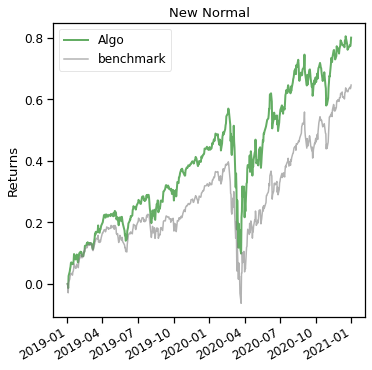

In [51]:
%matplotlib inline

baseline_df = get_baseline(
        ticker='SUSA', start='2019-01-01', end='2021-01-01'
    )

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                       benchmark_rets=baseline_returns, set_context=False)